# Markout analysis

Some code that looks into markouts, both Binance-based and Uniswap-based. There appear to be some issues in this


In [1]:
pool_name_ = "USDC-ETH-0.05"
# pool_name_ = "ETH-USDT-0.05"
# pool_name_ = "WBTC-ETH-0.05"

In [2]:
import pandas as pd
swap_data_ = pd.read_csv(f"./data/pairs-golden-dataset-dont-fuck-with/{pool_name_}-swap_data.csv")\
    .rename(columns={"Unnamed: 0": "txnIndex"})\
    .drop_duplicates()\
    .set_index("txnIndex")

sandwich_data_ = pd.read_csv(f"./data/pairs-golden-dataset-dont-fuck-with/{pool_name_}-sandwich_data.csv")\
    .rename(columns={"Unnamed: 0": "blockTimestamp"})\
    .drop_duplicates()\
    .set_index("blockTimestamp")


In [176]:
swap_data_

,blockTimestamp,blockNumber,logIndex,txnHash,origin,sender,gasUsed,gasPrice,amount0,amount1,...,viaRouter,price0After,price1After,informed,binance_price_token1_pre_block,binance_price_token1_1m_lag,binance_price_token1_5m_lag,binance_price_token1_10m_lag,binance_price_token1_30m_lag,binance_price_token1_60m_lag
txnIndex,,,,,,,,,,,,,,,,,,,,,
0,1.656648e+09,15054304,14,0xdb7f72d403272b8bd35b907fe4f1ddd547083ae0d72a...,0x7aa0426f10c7603bbfb8ceb8afb8d8c329ccfe8b,0x000000000035b5e5ad9019092c665357240f594e,311559,40018271216,-403619.768287,383.154963,...,0,0.000949,1053.205792,False,1054.85,1053.53,1047.79,1051.59,1052.74,1051.02
1,1.656648e+09,15054304,22,0xe6fedc626e1593f58d4201880a8b3fee0fece3216d84...,0x7717275de7e38ec247b0426ac4fcb22903b7bbcf,0xdef1c0ded9bec7f1a1670819833240f027b25eff,784940,41528271216,-553827.698939,526.615385,...,0x Router,0.000951,1051.190060,False,1054.85,1053.53,1047.79,1051.59,1052.74,1051.02
2,1.656648e+09,15054304,43,0x2f42d1de920679b42ccc139e4aa749ae06907c505380...,0x7aa0426f10c7603bbfb8ceb8afb8d8c329ccfe8b,0x000000000035b5e5ad9019092c665357240f594e,339791,2353779246764,403619.768286,-383.503705,...,0,0.000950,1052.659942,False,1054.85,1053.53,1047.79,1051.59,1052.74,1051.02
3,1.656648e+09,15054304,46,0x65436d514ed78dbade7d588217ecef714b758d89a96f...,0xafdc6373e653fcbd4583f41e2a5742cfcb5effc7,0x4cb18386e5d1f34dc6eea834bf3534a970a3f8e7,900000,41528271216,666942.949886,-632.535202,...,0,0.000948,1055.080199,True,1054.85,1053.53,1047.79,1051.59,1052.74,1051.02
4,1.656648e+09,15054304,49,0xa3acb92e0bcedd34b04a8eb487e28f8fd0a85fb72536...,0x5c9a55199a4baeebe16a3c194f5c3abccc145860,0x596183ad5b82a845f43ce6826cb80bdfaa38187e,148474,40018271216,-261866.937709,248.432398,...,0,0.000949,1054.129108,True,1054.85,1053.53,1047.79,1051.59,1052.74,1051.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629777,1.672549e+09,16309680,125,0x5fad24b31219b11a2a9f339348f72528007affb315b1...,0x7d2cf30b4506737864ce3e859928c3fec9d92fcb,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,240980,16597514667,1800.000000,-1.509550,...,V3 router 2,0.000839,1191.814280,False,1192.71,1192.87,1193.34,1193.14,1194.26,1194.85
1629778,1.672549e+09,16309680,187,0x003fd7a928c75aa99b940a3e1ad58c485786ce88bfb7...,0xb88224848b7a75c1dc06d70ba95c68c4f023cc80,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,240922,16597514667,60.000000,-0.050318,...,V3 router 2,0.000839,1191.814407,False,1192.71,1192.87,1193.34,1193.14,1194.26,1194.85
1629779,1.672549e+09,16309681,19,0xb9b54747058694d90b5fc0c1554ca369342150eb92b3...,0x6339ba8a94333d13a39f74a6b8cb2209516f8183,0x1111111254fb6c44bac0bed2854e76f90643097d,482258,15378000000,-262.068008,0.220000,...,1inch V4 Router,0.000839,1191.813851,False,1192.71,1192.87,1193.34,1193.14,1194.26,1194.85


In [177]:
# make the mapping from discrete times to price
time_to_price_ = {}
for i, row_ in swap_data_.iterrows():
    time_to_price_[row_.blockTimestamp] = row_.price0After

time_to_price_ = list(sorted([(k, v) for (k, v) in time_to_price_.items()], key=lambda x: x[0]))

In [178]:
# make mapping from continuous times to price
from bisect import bisect_right

def find_le(a, x, key):
    # Find rightmost value less than or equal to x
    i = bisect_right(a, x, key=key)
    if i:
        return a[i-1]
    raise ValueError

def price_at_timestamp(t):
    time_and_price = find_le(time_to_price_, t, key=lambda x: x[0])
    return time_and_price[1]

In [179]:
# bring it all together!
h_minutes_ = 5

lp_d_ = swap_data_.boughtToken0.apply(lambda x: -1 if x==1 else 1)
size_ = swap_data_.amount0
p_lp_avg_ = -swap_data_.amount1/swap_data_.amount0 # gets the average execution price, for the Uniswap LP


allmarkoutcols_ = []
LAGS_ = [5, 10, 15, 30, 45, 60, 90, 120, 720]
for h_minutes_ in LAGS_:
    p_after_lag_ = swap_data_.blockTimestamp.apply(lambda t: price_at_timestamp(t + h_minutes_* 60))
    markout_ = lp_d_ * size_ * (p_after_lag_-p_lp_avg_)

    allmarkoutcols_.append(f"markout_{h_minutes_}m")
    swap_data_[allmarkoutcols_[-1]] = markout_
    

# # only run this on ETH-USDT pool
# BINANCE_LAGS_ = [1, 5, 10, 30, 60]
# for h_minutes_ in BINANCE_LAGS_:
#     p_after_lag_ = swap_data_.blockTimestamp.apply(lambda t: price_at_timestamp(t + h_minutes_* 60))
#     markout_ = lp_d_ * size_ * (swap_data_[f"binance_price_token0_{h_minutes_}m_lag"]-p_lp_avg_)

#     allmarkoutcols_.append(f"markout_{h_minutes_}m_binance")
#     swap_data_[allmarkoutcols_[-1]] = markout_
    
swap_data_

,blockTimestamp,blockNumber,logIndex,txnHash,origin,sender,gasUsed,gasPrice,amount0,amount1,...,binance_price_token1_60m_lag,markout_5m,markout_10m,markout_15m,markout_30m,markout_45m,markout_60m,markout_90m,markout_120m,markout_720m
txnIndex,,,,,,,,,,,,,,,,,,,,,
0,1.656648e+09,15054304,14,0xdb7f72d403272b8bd35b907fe4f1ddd547083ae0d72a...,0x7aa0426f10c7603bbfb8ceb8afb8d8c329ccfe8b,0x000000000035b5e5ad9019092c665357240f594e,311559,40018271216,-403619.768287,383.154963,...,1051.02,1.650497,0.207419,2.011145,2.705088,0.146752,1.503877,-1.715945,-0.756551,-0.873657
1,1.656648e+09,15054304,22,0xe6fedc626e1593f58d4201880a8b3fee0fece3216d84...,0x7717275de7e38ec247b0426ac4fcb22903b7bbcf,0xdef1c0ded9bec7f1a1670819833240f027b25eff,784940,41528271216,-553827.698939,526.615385,...,1051.02,1.396222,-0.583900,1.891086,2.843281,-0.667145,1.195037,-3.223048,-1.906614,-2.067301
2,1.656648e+09,15054304,43,0x2f42d1de920679b42ccc139e4aa749ae06907c505380...,0x7aa0426f10c7603bbfb8ceb8afb8d8c329ccfe8b,0x000000000035b5e5ad9019092c665357240f594e,339791,2353779246764,403619.768286,-383.503705,...,1051.02,1.301755,-0.141323,1.662402,2.356346,-0.201991,1.155134,-2.064687,-1.105293,-1.222399
3,1.656648e+09,15054304,46,0x65436d514ed78dbade7d588217ecef714b758d89a96f...,0xafdc6373e653fcbd4583f41e2a5742cfcb5effc7,0x4cb18386e5d1f34dc6eea834bf3534a970a3f8e7,900000,41528271216,666942.949886,-632.535202,...,1051.02,3.318908,0.934360,3.914844,5.061518,0.834113,3.076632,-2.243814,-0.658508,-0.852014
4,1.656648e+09,15054304,49,0xa3acb92e0bcedd34b04a8eb487e28f8fd0a85fb72536...,0x5c9a55199a4baeebe16a3c194f5c3abccc145860,0x596183ad5b82a845f43ce6826cb80bdfaa38187e,148474,40018271216,-261866.937709,248.432398,...,1051.02,1.227889,0.291626,1.461876,1.912104,0.252265,1.132762,-0.956245,-0.333794,-0.409772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629777,1.672549e+09,16309680,125,0x5fad24b31219b11a2a9f339348f72528007affb315b1...,0x7d2cf30b4506737864ce3e859928c3fec9d92fcb,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,240980,16597514667,1800.000000,-1.509550,...,1194.85,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752
1629778,1.672549e+09,16309680,187,0x003fd7a928c75aa99b940a3e1ad58c485786ce88bfb7...,0xb88224848b7a75c1dc06d70ba95c68c4f023cc80,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,240922,16597514667,60.000000,-0.050318,...,1194.85,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025
1629779,1.672549e+09,16309681,19,0xb9b54747058694d90b5fc0c1554ca369342150eb92b3...,0x6339ba8a94333d13a39f74a6b8cb2209516f8183,0x1111111254fb6c44bac0bed2854e76f90643097d,482258,15378000000,-262.068008,0.220000,...,1194.85,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110


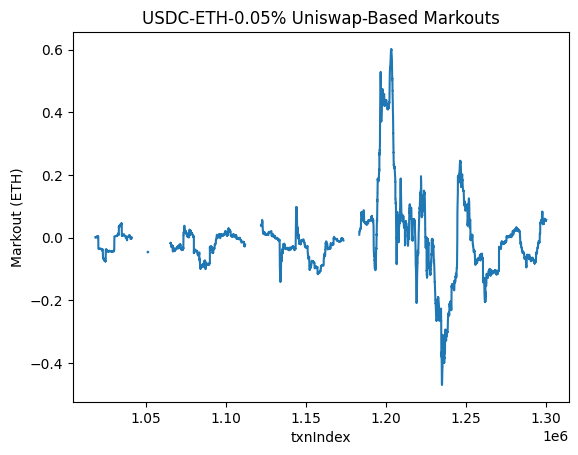

In [182]:
uniswap_based_markout_cols_ = [
    f"markout_{lag_}m"
    for lag_ in LAGS_[:-3]
]
swap_data_[
    #uniswap_based_markout_cols_
    "markout_15m"
].iloc[int(1.0e6):int(1.3e6)].rolling(10_000).mean().plot()
plt.title(f"{pool_name_}% Uniswap-Based Markouts")
plt.ylabel("Markout (ETH)");

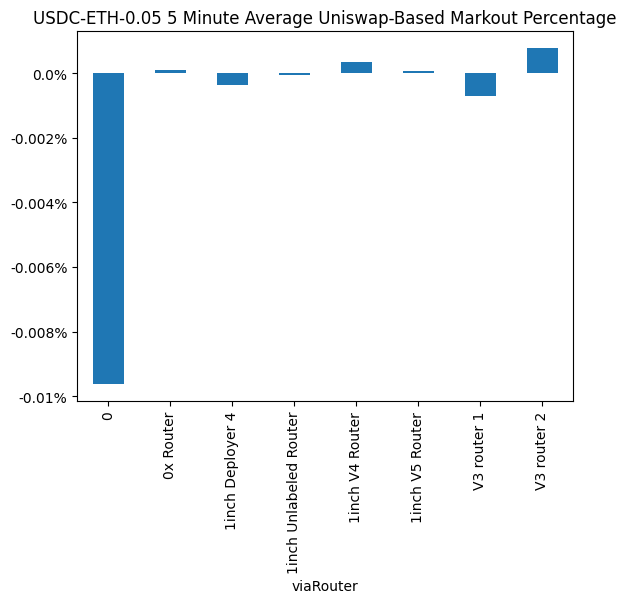

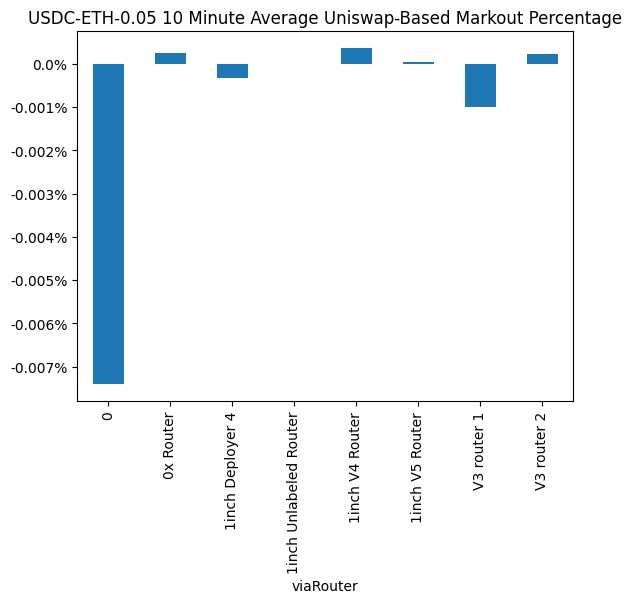

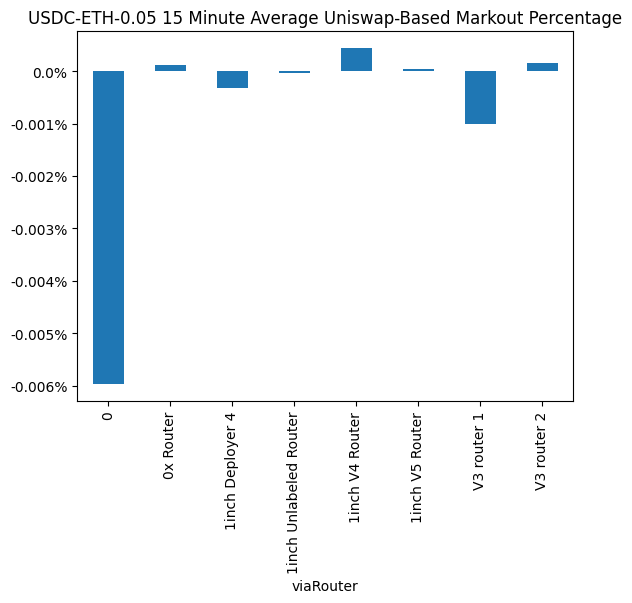

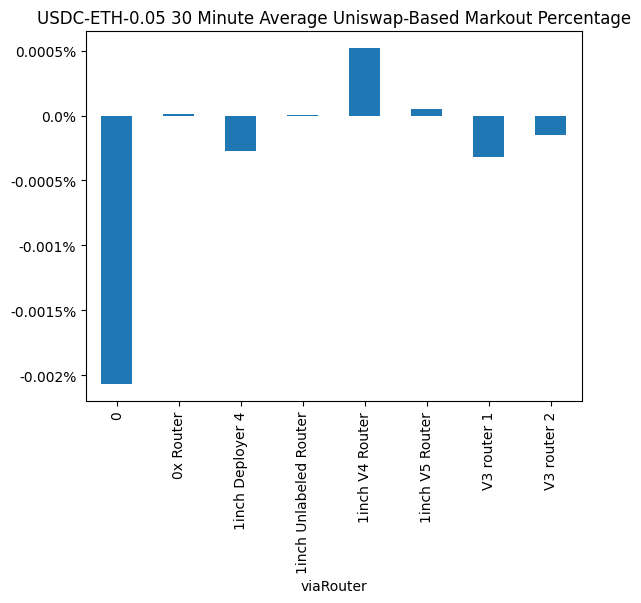

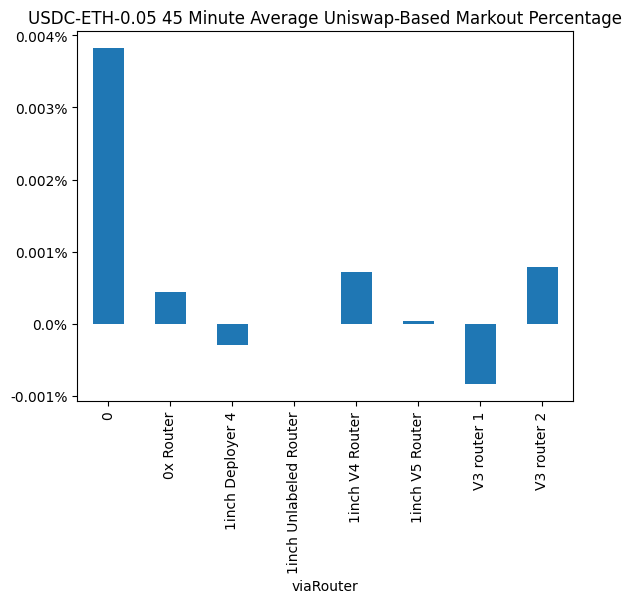

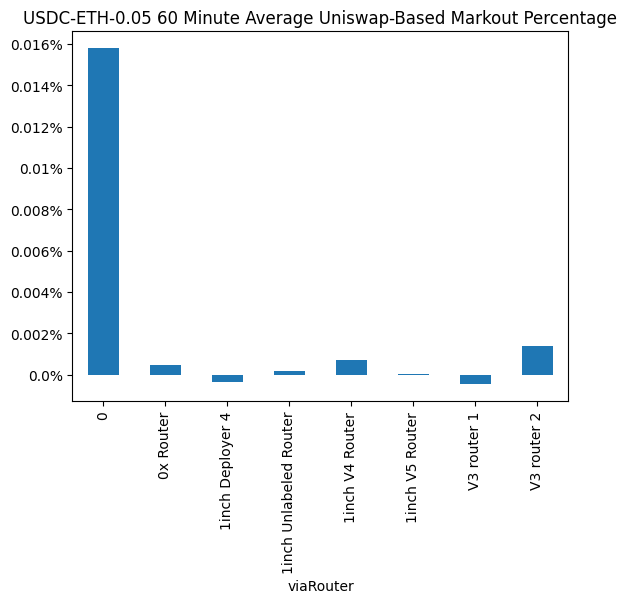

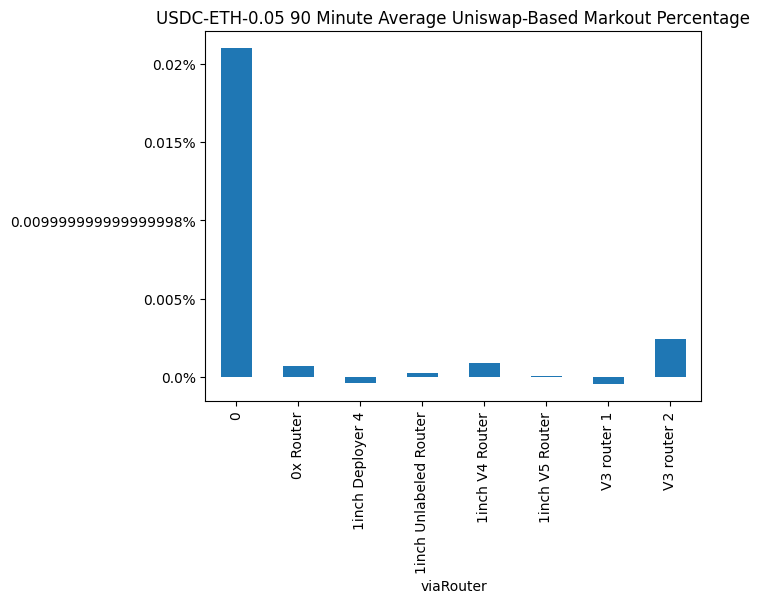

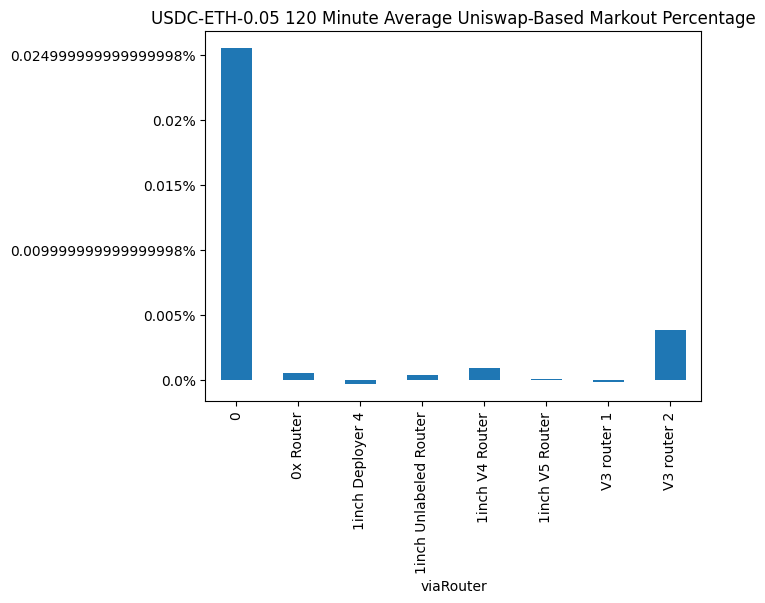

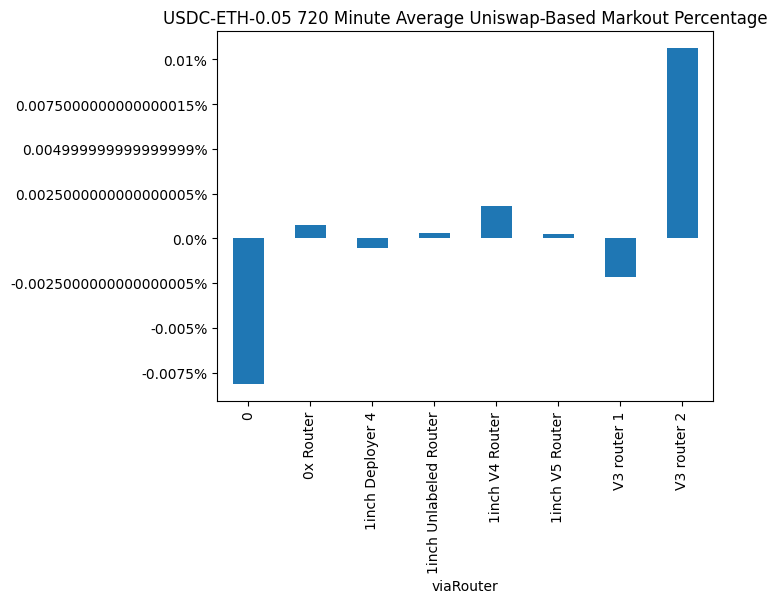

In [183]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# interestingly, approximately 2.5 bps of markout from the V3 router 1!
for h_minutes_ in LAGS_:
    ax = (
        100*swap_data_.groupby("viaRouter")[f"markout_{h_minutes_}m"].sum() /
        swap_data_.groupby("viaRouter", group_keys=False)["amount1"].apply(np.abs).sum()
    ).plot.bar()
    ax.set_title(f"{pool_name_} {h_minutes_} Minute Average Uniswap-Based Markout Percentage")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{}%'.format(y))) 
    plt.show()
    
# for h_minutes_ in LAGS_:
#     ax = (
#         100*swap_data_.groupby("viaRouter")[f"markout_{h_minutes_}m_binance"].sum() /
#         swap_data_.groupby("viaRouter", group_keys=False)["amount1"].apply(np.abs).sum()
#     ).plot.bar()
#     ax.set_title(f"{pool_name_}% {h_minutes_} Minute Average Binance-Based Markout Percentage")
#     ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{}%'.format(y))) 
#     plt.show()



In [119]:
txn_type_ = swap_data_.txnHash.apply(categorize_txn)
swap_data_[txn_type_ == "Unrelated"][allmarkoutcols_]

,markout_1m_binance,markout_5m_binance,markout_10m_binance,markout_30m_binance,markout_60m_binance
txnIndex,,,,,
0,-7.336953,-23.642029,-12.847728,-9.581032,-14.466873
1,-3.570235,-10.937030,-6.060058,-4.584132,-6.791604
2,-3.427817,-205.102990,-71.589809,-31.184505,-91.616786
3,-31.126124,-32.109468,-37.222853,33.086201,-30.437784
4,-21.739776,-22.296395,-25.190813,14.607438,-21.350143
...,...,...,...,...,...
644368,-0.333319,1.123093,1.487196,2.729430,3.736067
644369,12.238815,15.721815,15.640815,23.092815,25.846815
644370,2.011302,4.599906,4.539705,10.078113,12.124916


In [94]:
# plt.scatter(
#     swap_data_.markout_10m,
#     swap_data_.amount1.abs(),
#     s=.3*len(swap_data_)
# )
# plt.xlabel("Markout 10m")
# plt.ylabel("Trade Size");

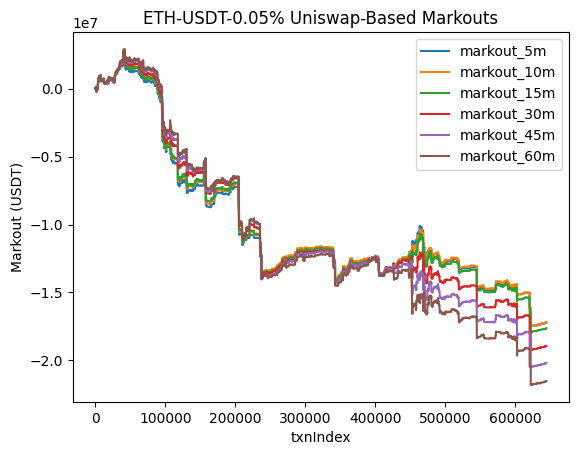

In [134]:
uniswap_based_markout_cols_ = [
    f"markout_{binance_lag_}m"
    for binance_lag_ in LAGS_[:-3]
]
swap_data_[uniswap_based_markout_cols_].cumsum().plot()
plt.title(f"{pool_name_}% Uniswap-Based Markouts")
plt.ylabel("Markout (USDT)");

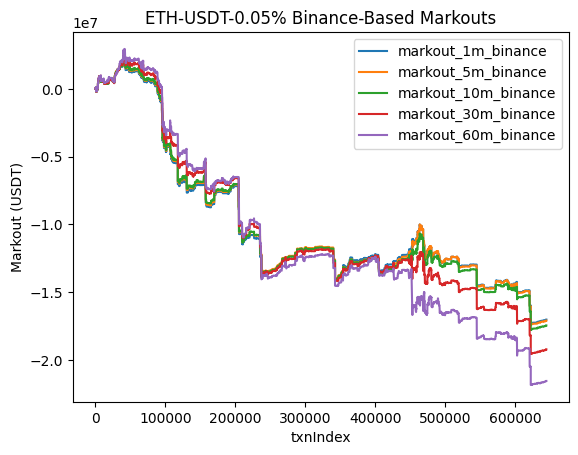

In [135]:
binance_markout_cols_ = [
    f"markout_{binance_lag_}m_binance"
    for binance_lag_ in BINANCE_LAGS_
]
swap_data_[binance_markout_cols_].cumsum().plot()
plt.title(f"{pool_name_}% Binance-Based Markouts")
plt.ylabel("Markout (USDT)");

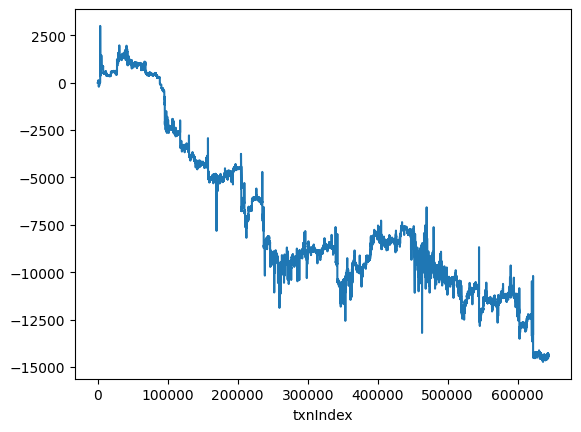

In [97]:
(swap_data_["markout_10m"].cumsum()*swap_data_.price1After).plot();

## Sandwich disaggregation

In [92]:
sandwich_bun_txns_ = set(sandwich_data_.top_bun_txn.values).union(set(sandwich_data_.bottom_bun_txn.values))
meat_txns_ = set(sandwich_data_.meat_txn.values)
sandwich_related_txns_ = meat_txns_.union(sandwich_bun_txns_)

<AxesSubplot: xlabel='txnIndex'>

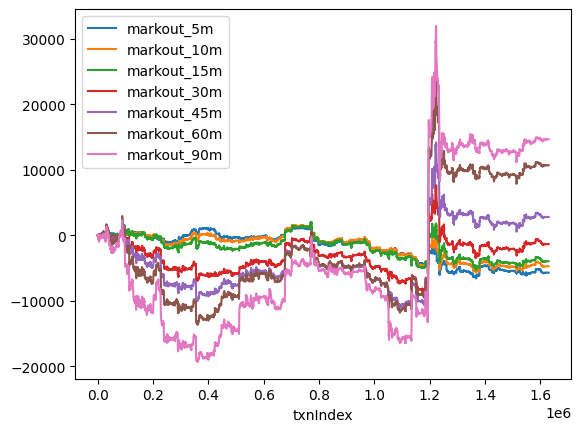

In [198]:
swap_data_[allmarkoutcols[:-2]].cumsum().plot()

<AxesSubplot: xlabel='txnIndex'>

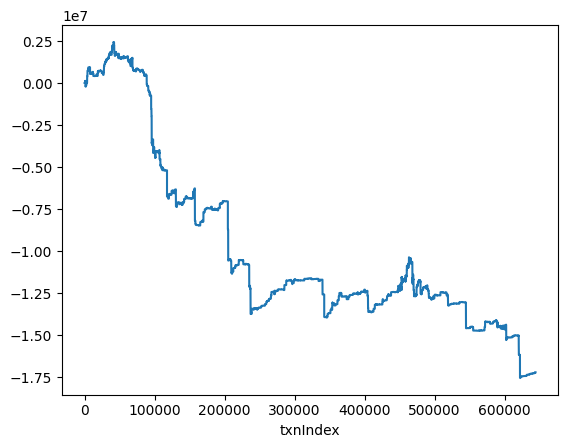

In [98]:
s_ = pd.concat([
    swap_data_.iloc[
        :int(1.19e6)
    ],
    swap_data_.iloc[
        int(1.23e6):
    ]
])

s_.markout_10m.cumsum().plot()

# .markout_10m.plot()

# sns.histplot(swap_data_.markout_10m)

In [220]:
def markout_graphs(groupby, data=swap_data_):
    for h_minutes_ in LAGS_:
        ax = (
            100*data.groupby(groupby)[f"markout_{h_minutes_}m"].sum() /
            data.groupby(groupby, group_keys=False)["amount1"].apply(np.abs).sum()
        ).plot.bar()
        ax.set_title(f"{pool_name_} {h_minutes_} Minute Average Uniswap-Based Markout Percentage")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.4f}%'.format(y))) 
        plt.show()


In [222]:
# swap_data_.groupby(s_.txnHash.apply(categorize_txn))

Coefficients for the OLS regression.
b=0.0007
m=-0.0007

T test values for the OLS regression.
const      1.909116
amount1   -2.267804
dtype: float64


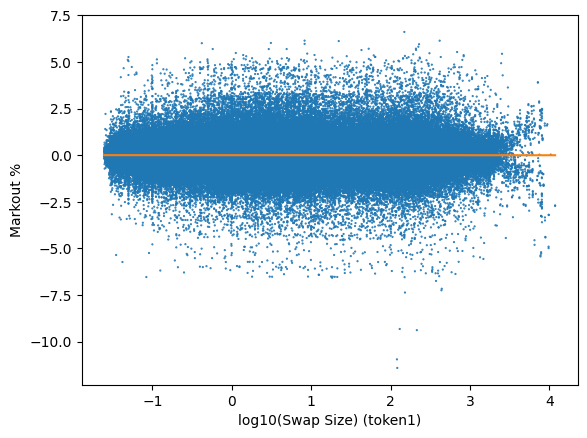

In [223]:
import statsmodels.api as sm

s_ = swap_data_[swap_data_.amount0.abs() >= 50] # orders larger than 50 USDC
markout_pct_ = (
    100 * s_.markout_10m / s_.amount1.abs()
)

# k_ = 800_000
y_ = markout_pct_
x_ = s_.amount1.abs().apply(np.log10)

plt.scatter(
    x_,
    y_,
    s=[.3]*len(x_)
)
plt.ylabel("Markout %")
plt.xlabel("log10(Swap Size) (token1)");

x_ = sm.add_constant(x_)

ols_results_ = sm.OLS(y_, x_).fit()
b_, m_ = ols_results_.params

print(f"Coefficients for the OLS regression.\nb={b_:<.4f}\nm={m_:<.4f}\n")
print(f"T test values for the OLS regression.\n{ols_results_.tvalues}")

x_vals_ = np.linspace(x_.min(), x_.max(), 300)
y_vals_ = np.array([b_ + m_*x_val_ for x_val_ in x_vals_])

plt.plot(
    x_vals_,
    y_vals_
)


In [224]:
def is_non_sandwich(txn_hash):
    return (txn_hash not in meat_txns_) and (txn_hash not in sandwich_bun_txns_)

non_sandwich_related_swaps_ = swap_data_[swap_data_.txnHash.apply(is_non_sandwich)]
non_sandwich_related_swaps_

,blockTimestamp,blockNumber,logIndex,txnHash,origin,sender,gasUsed,gasPrice,amount0,amount1,...,binance_price_token1_60m_lag,markout_5m,markout_10m,markout_15m,markout_30m,markout_45m,markout_60m,markout_90m,markout_120m,markout_720m
txnIndex,,,,,,,,,,,,,,,,,,,,,
0,1.656648e+09,15054304,14,0xdb7f72d403272b8bd35b907fe4f1ddd547083ae0d72a...,0x7aa0426f10c7603bbfb8ceb8afb8d8c329ccfe8b,0x000000000035b5e5ad9019092c665357240f594e,311559,40018271216,-403619.768287,383.154963,...,1051.02,1.650497,0.207419,2.011145,2.705088,0.146752,1.503877,-1.715945,-0.756551,-0.873657
1,1.656648e+09,15054304,22,0xe6fedc626e1593f58d4201880a8b3fee0fece3216d84...,0x7717275de7e38ec247b0426ac4fcb22903b7bbcf,0xdef1c0ded9bec7f1a1670819833240f027b25eff,784940,41528271216,-553827.698939,526.615385,...,1051.02,1.396222,-0.583900,1.891086,2.843281,-0.667145,1.195037,-3.223048,-1.906614,-2.067301
2,1.656648e+09,15054304,43,0x2f42d1de920679b42ccc139e4aa749ae06907c505380...,0x7aa0426f10c7603bbfb8ceb8afb8d8c329ccfe8b,0x000000000035b5e5ad9019092c665357240f594e,339791,2353779246764,403619.768286,-383.503705,...,1051.02,1.301755,-0.141323,1.662402,2.356346,-0.201991,1.155134,-2.064687,-1.105293,-1.222399
3,1.656648e+09,15054304,46,0x65436d514ed78dbade7d588217ecef714b758d89a96f...,0xafdc6373e653fcbd4583f41e2a5742cfcb5effc7,0x4cb18386e5d1f34dc6eea834bf3534a970a3f8e7,900000,41528271216,666942.949886,-632.535202,...,1051.02,3.318908,0.934360,3.914844,5.061518,0.834113,3.076632,-2.243814,-0.658508,-0.852014
4,1.656648e+09,15054304,49,0xa3acb92e0bcedd34b04a8eb487e28f8fd0a85fb72536...,0x5c9a55199a4baeebe16a3c194f5c3abccc145860,0x596183ad5b82a845f43ce6826cb80bdfaa38187e,148474,40018271216,-261866.937709,248.432398,...,1051.02,1.227889,0.291626,1.461876,1.912104,0.252265,1.132762,-0.956245,-0.333794,-0.409772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629777,1.672549e+09,16309680,125,0x5fad24b31219b11a2a9f339348f72528007affb315b1...,0x7d2cf30b4506737864ce3e859928c3fec9d92fcb,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,240980,16597514667,1800.000000,-1.509550,...,1194.85,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752
1629778,1.672549e+09,16309680,187,0x003fd7a928c75aa99b940a3e1ad58c485786ce88bfb7...,0xb88224848b7a75c1dc06d70ba95c68c4f023cc80,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,240922,16597514667,60.000000,-0.050318,...,1194.85,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025
1629779,1.672549e+09,16309681,19,0xb9b54747058694d90b5fc0c1554ca369342150eb92b3...,0x6339ba8a94333d13a39f74a6b8cb2209516f8183,0x1111111254fb6c44bac0bed2854e76f90643097d,482258,15378000000,-262.068008,0.220000,...,1194.85,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110,-0.000110


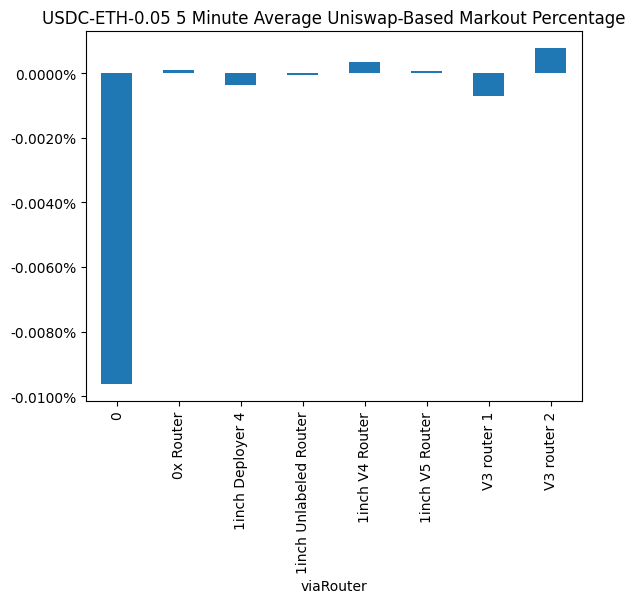

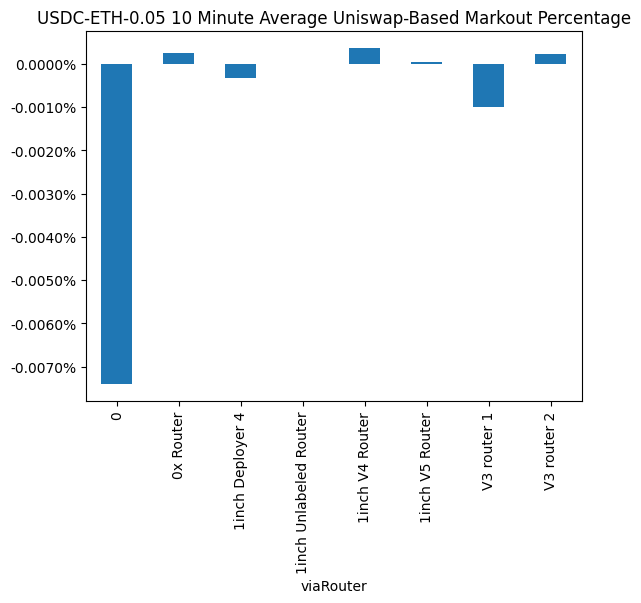

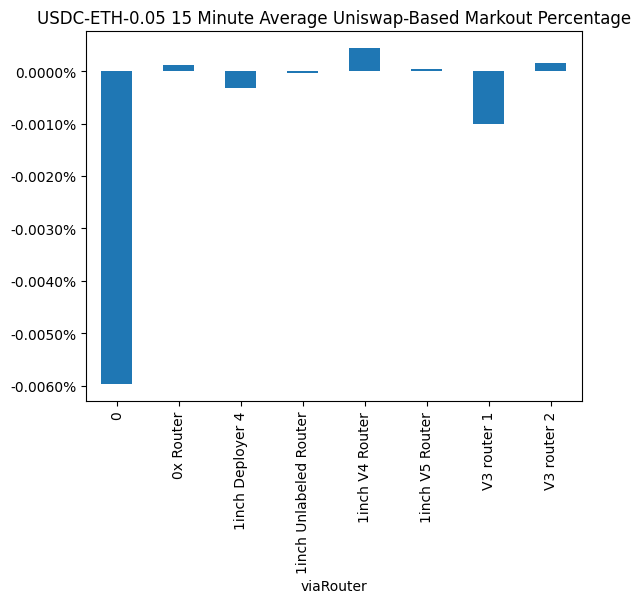

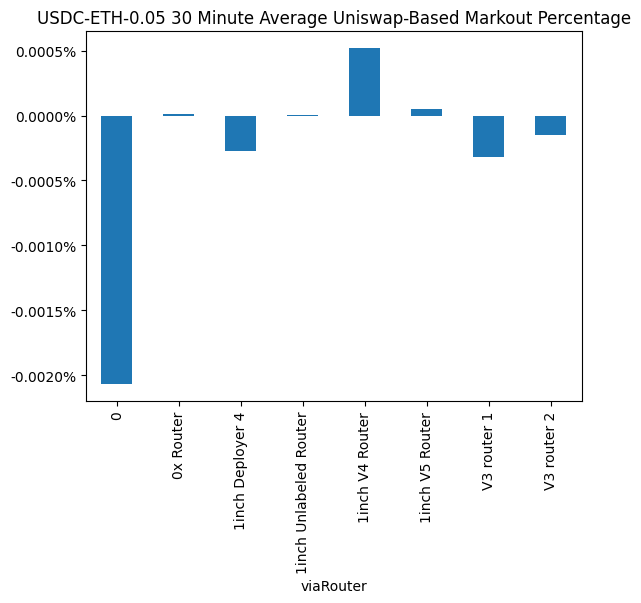

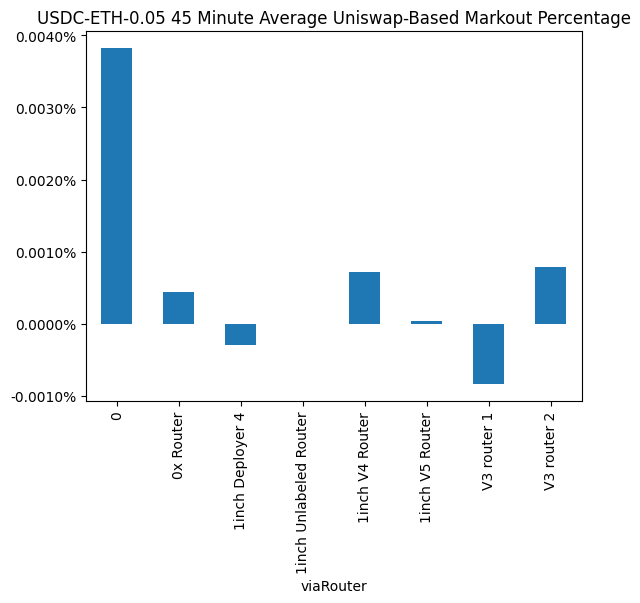

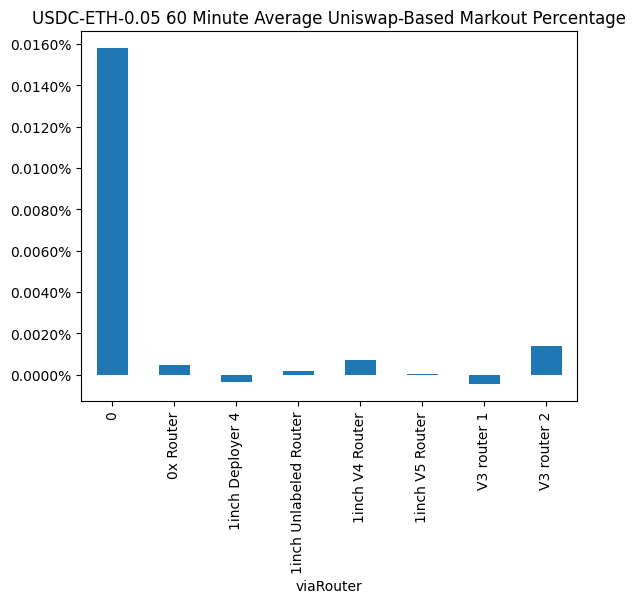

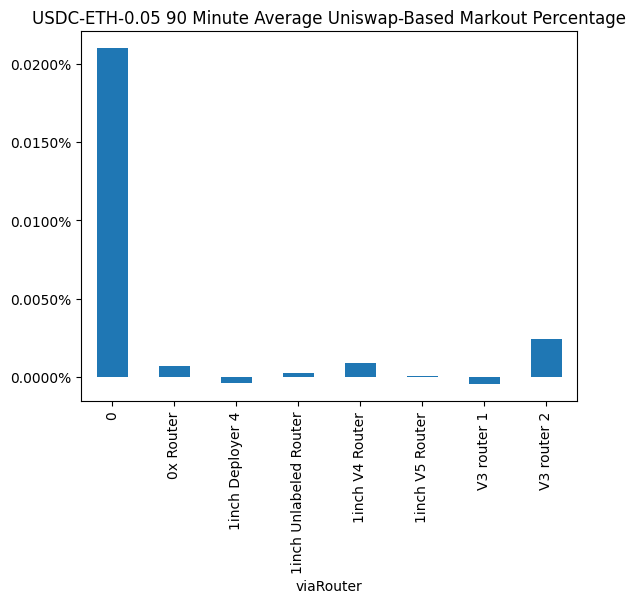

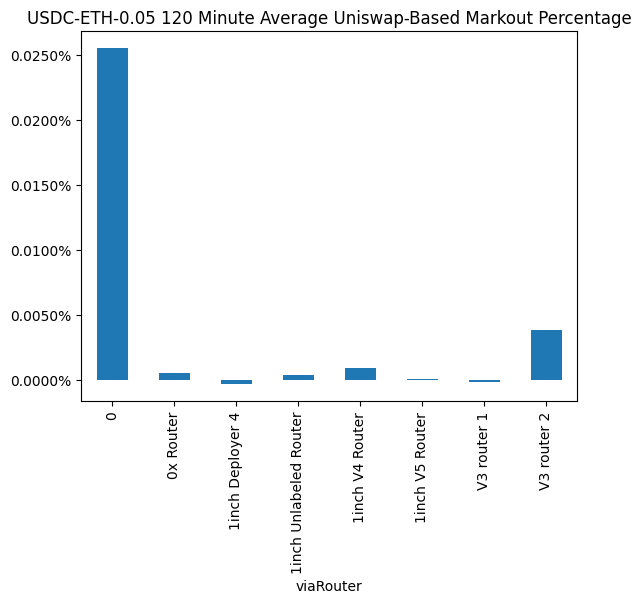

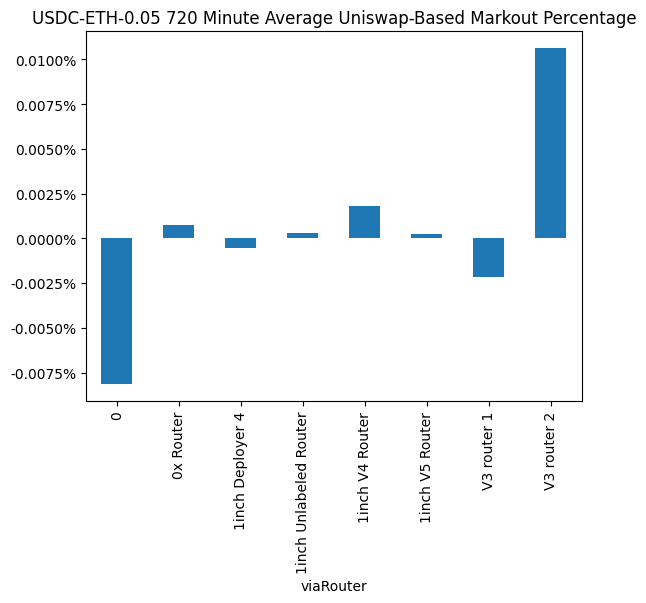

In [225]:
markout_graphs("viaRouter", swap_data_)

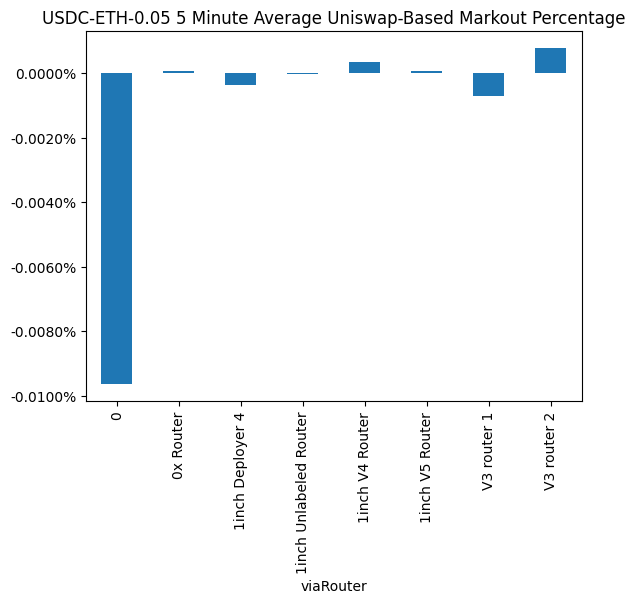

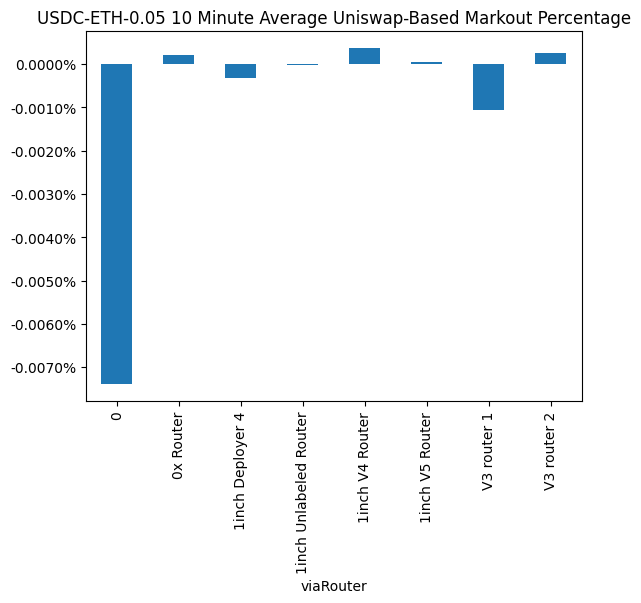

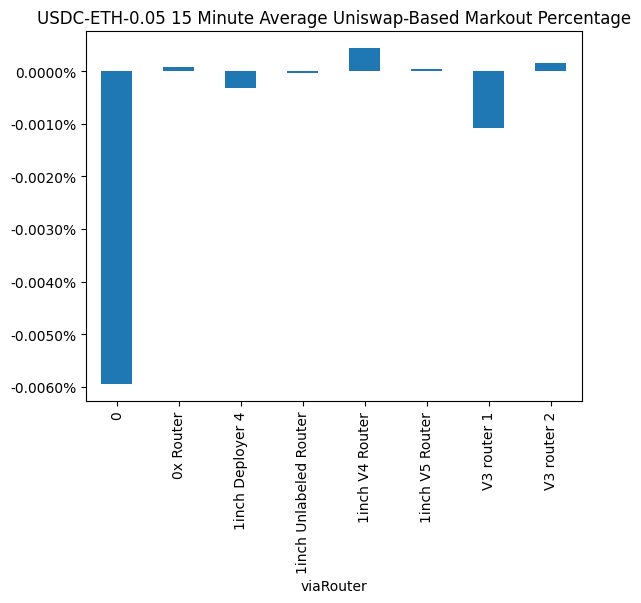

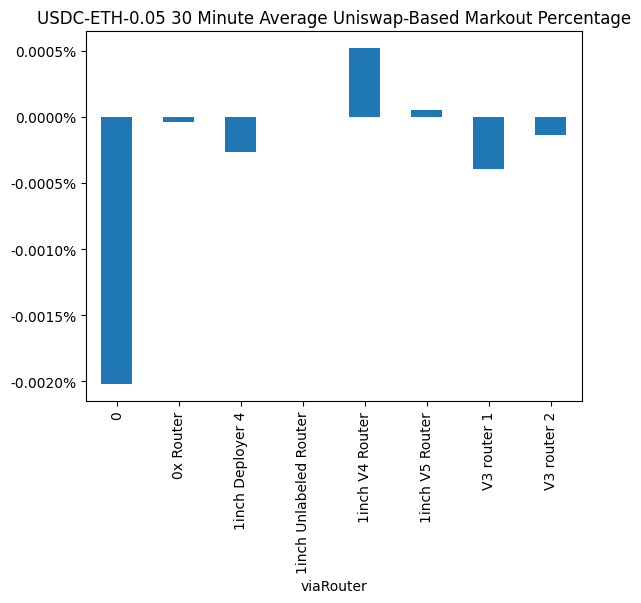

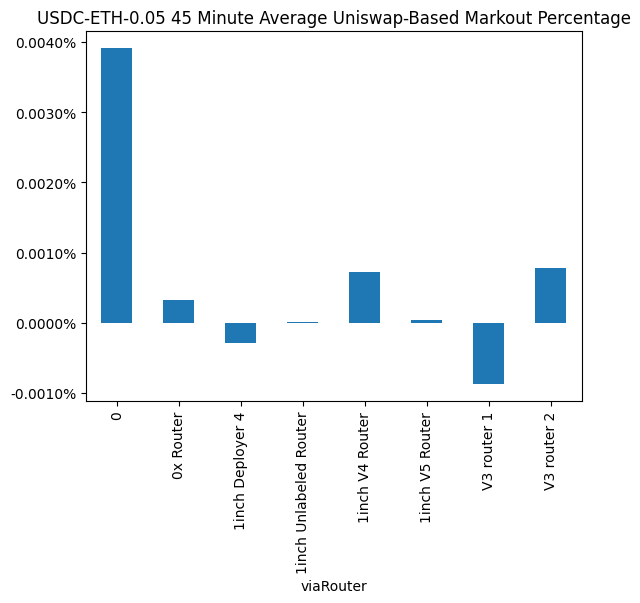

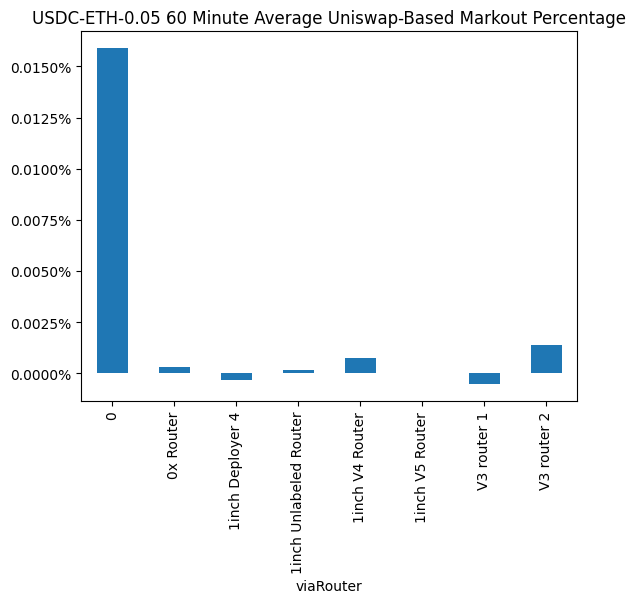

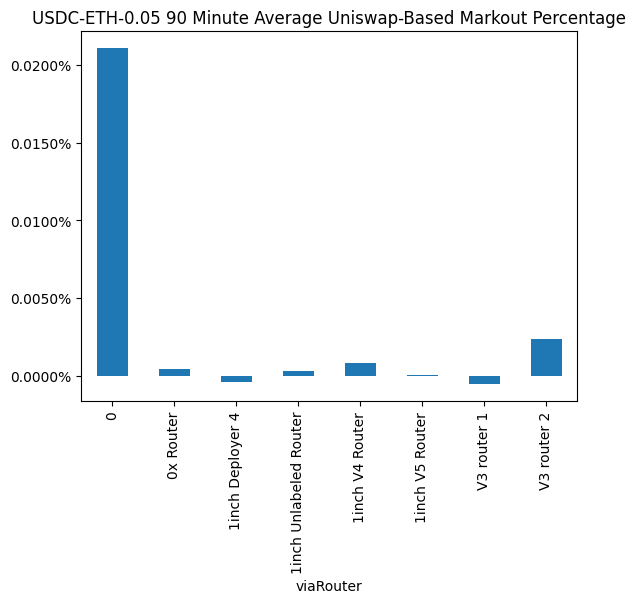

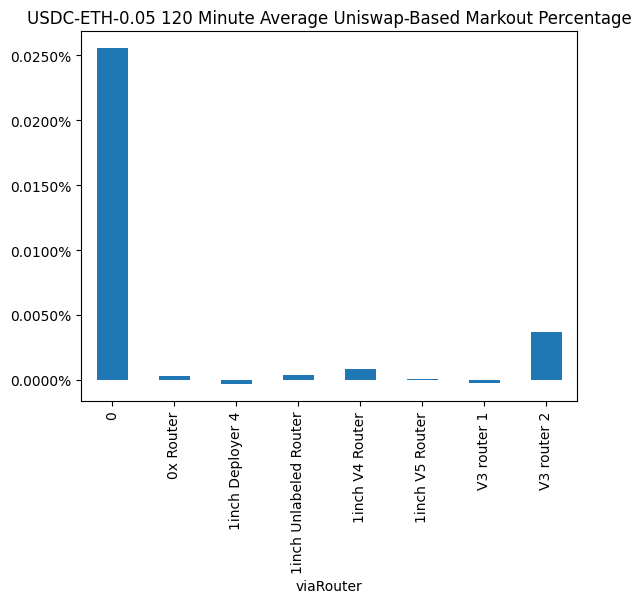

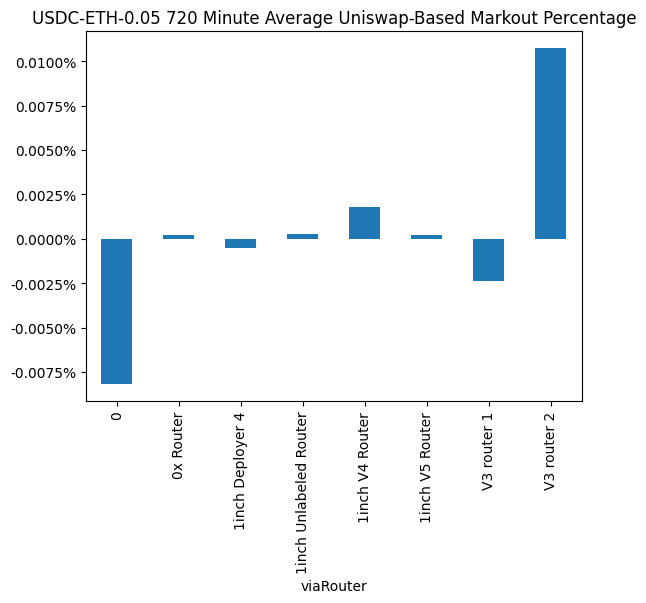

In [226]:
markout_graphs("viaRouter", non_sandwich_related_swaps_)

viaRouter
0                        -0.009648
0x Router                 0.000063
1inch Deployer 4         -0.000364
1inch Unlabeled Router   -0.000036
1inch V4 Router           0.000337
1inch V5 Router           0.000059
V3 router 1              -0.000703
V3 router 2               0.000768
Name: markout_5m, dtype: float64


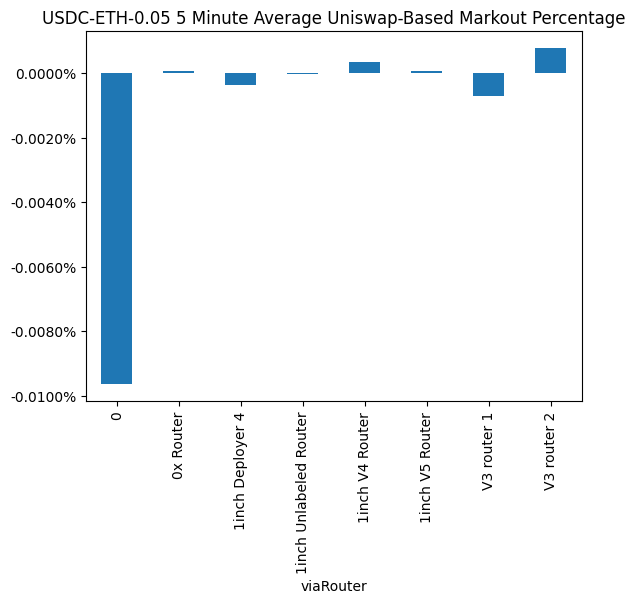

viaRouter
0                        -0.007396
0x Router                 0.000207
1inch Deployer 4         -0.000330
1inch Unlabeled Router   -0.000018
1inch V4 Router           0.000360
1inch V5 Router           0.000047
V3 router 1              -0.001063
V3 router 2               0.000259
Name: markout_10m, dtype: float64


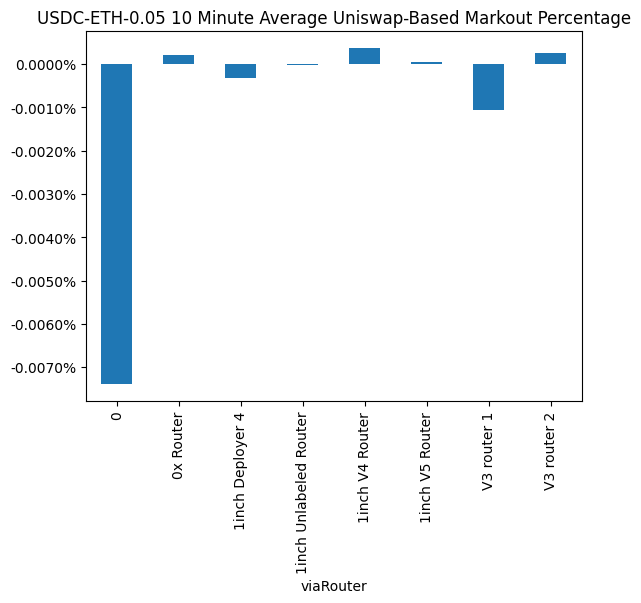

viaRouter
0                        -0.005953
0x Router                 0.000077
1inch Deployer 4         -0.000319
1inch Unlabeled Router   -0.000035
1inch V4 Router           0.000437
1inch V5 Router           0.000040
V3 router 1              -0.001070
V3 router 2               0.000155
Name: markout_15m, dtype: float64


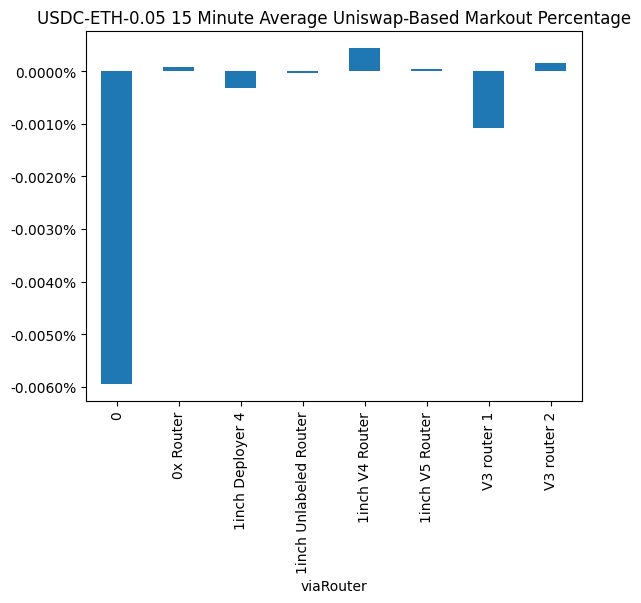

viaRouter
0                        -2.021557e-03
0x Router                -3.991399e-05
1inch Deployer 4         -2.680884e-04
1inch Unlabeled Router    1.903132e-07
1inch V4 Router           5.188054e-04
1inch V5 Router           5.043261e-05
V3 router 1              -3.968315e-04
V3 router 2              -1.366409e-04
Name: markout_30m, dtype: float64


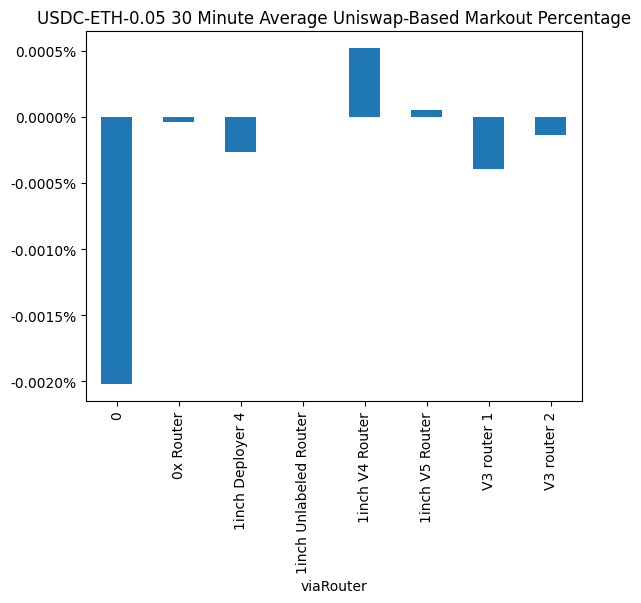

viaRouter
0                         0.003911
0x Router                 0.000328
1inch Deployer 4         -0.000294
1inch Unlabeled Router    0.000011
1inch V4 Router           0.000727
1inch V5 Router           0.000032
V3 router 1              -0.000879
V3 router 2               0.000779
Name: markout_45m, dtype: float64


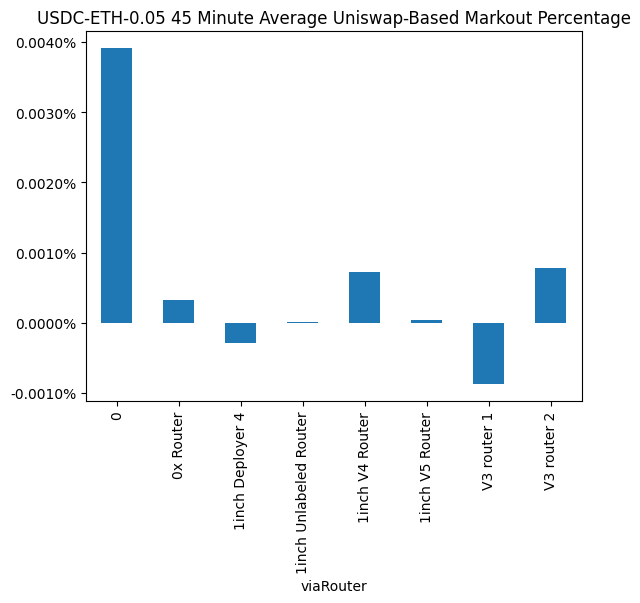

viaRouter
0                         0.015885
0x Router                 0.000326
1inch Deployer 4         -0.000328
1inch Unlabeled Router    0.000170
1inch V4 Router           0.000735
1inch V5 Router           0.000037
V3 router 1              -0.000537
V3 router 2               0.001369
Name: markout_60m, dtype: float64


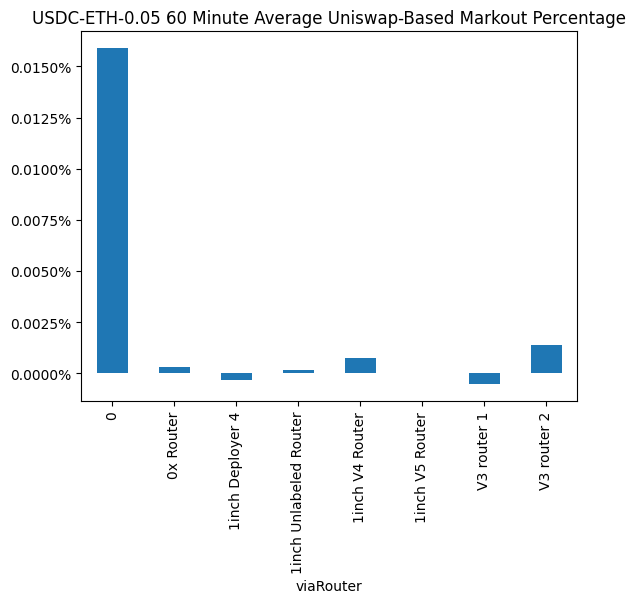

viaRouter
0                         0.021056
0x Router                 0.000457
1inch Deployer 4         -0.000397
1inch Unlabeled Router    0.000299
1inch V4 Router           0.000859
1inch V5 Router           0.000045
V3 router 1              -0.000539
V3 router 2               0.002372
Name: markout_90m, dtype: float64


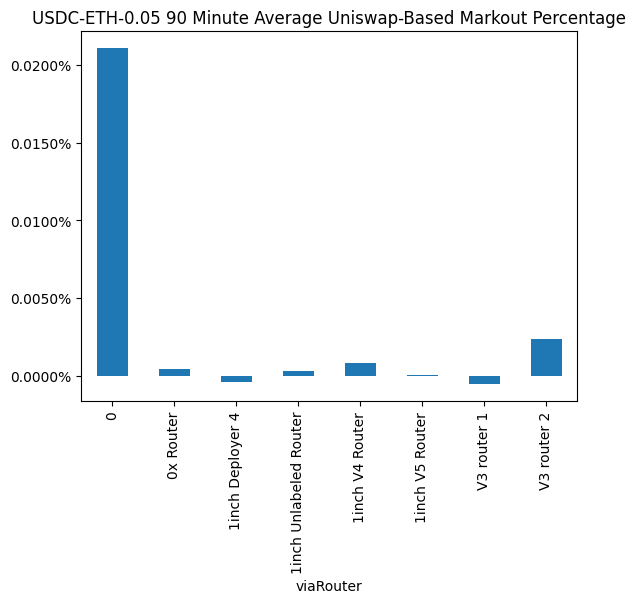

viaRouter
0                         0.025543
0x Router                 0.000282
1inch Deployer 4         -0.000323
1inch Unlabeled Router    0.000420
1inch V4 Router           0.000893
1inch V5 Router           0.000088
V3 router 1              -0.000190
V3 router 2               0.003729
Name: markout_120m, dtype: float64


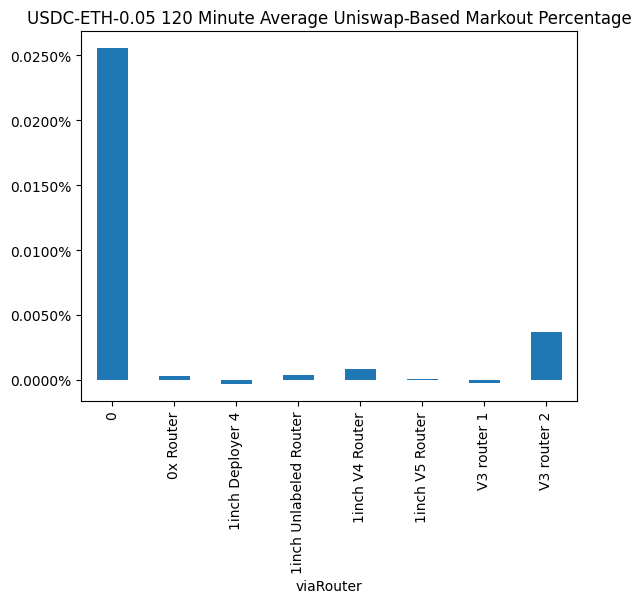

viaRouter
0                        -0.008191
0x Router                 0.000240
1inch Deployer 4         -0.000527
1inch Unlabeled Router    0.000283
1inch V4 Router           0.001803
1inch V5 Router           0.000227
V3 router 1              -0.002386
V3 router 2               0.010731
Name: markout_720m, dtype: float64


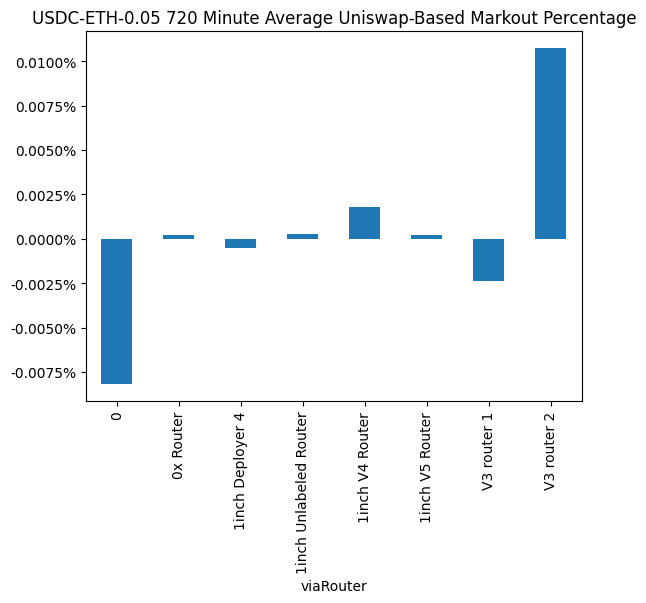

In [229]:
for h_minutes_ in LAGS_:
    datum_ = (
        100*non_sandwich_related_swaps_.groupby("viaRouter")[f"markout_{h_minutes_}m"].sum() /
        non_sandwich_related_swaps_.groupby("viaRouter", group_keys=False)["amount1"].apply(np.abs).sum()
    )
    ax = datum_.plot.bar()
    ax.set_title(f"{pool_name_} {h_minutes_} Minute Average Uniswap-Based Markout Percentage")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.4f}%'.format(y))) 
    print(datum_)
    plt.show()

viaRouter
0                        -0.009626
0x Router                 0.000092
1inch Deployer 4         -0.000365
1inch Unlabeled Router   -0.000043
1inch V4 Router           0.000337
1inch V5 Router           0.000059
V3 router 1              -0.000702
V3 router 2               0.000770
Name: markout_5m, dtype: float64


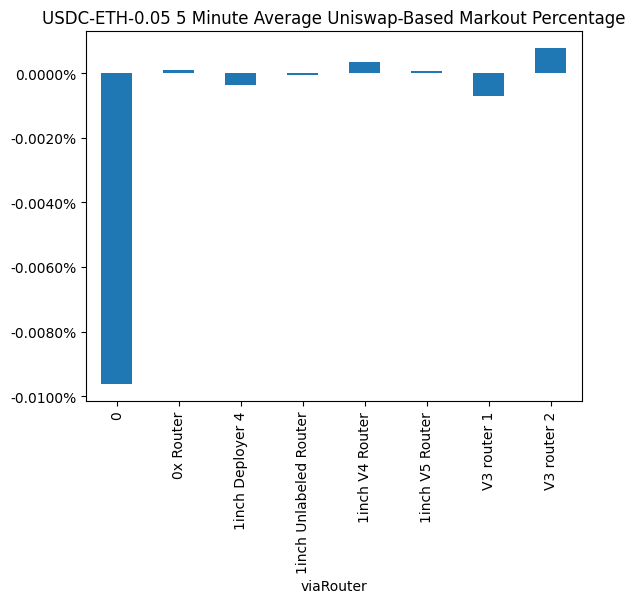

viaRouter
0                        -0.007407
0x Router                 0.000250
1inch Deployer 4         -0.000335
1inch Unlabeled Router   -0.000014
1inch V4 Router           0.000359
1inch V5 Router           0.000047
V3 router 1              -0.001008
V3 router 2               0.000234
Name: markout_10m, dtype: float64


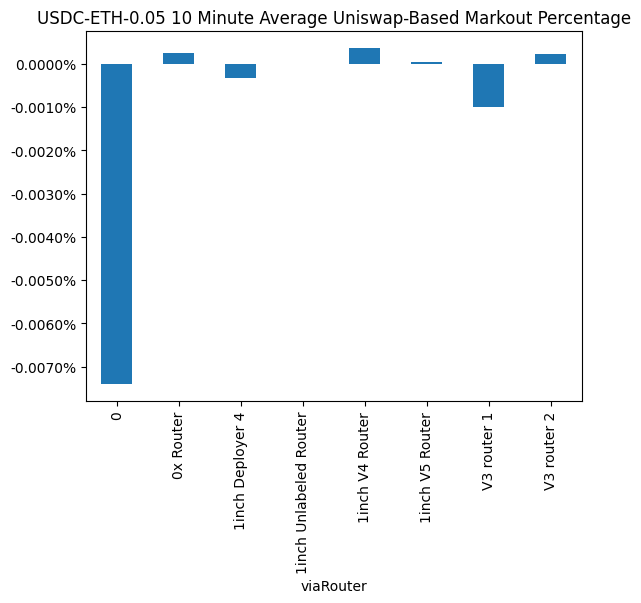

viaRouter
0                        -0.005972
0x Router                 0.000117
1inch Deployer 4         -0.000324
1inch Unlabeled Router   -0.000030
1inch V4 Router           0.000437
1inch V5 Router           0.000040
V3 router 1              -0.001001
V3 router 2               0.000148
Name: markout_15m, dtype: float64


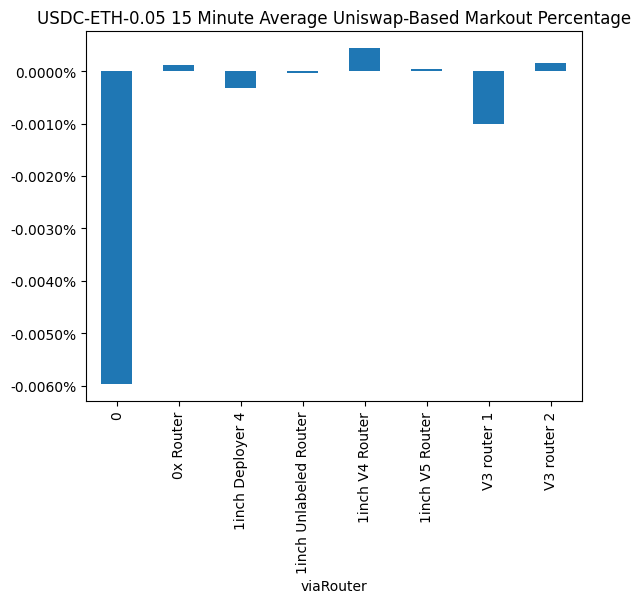

viaRouter
0                        -0.002070
0x Router                 0.000016
1inch Deployer 4         -0.000271
1inch Unlabeled Router    0.000006
1inch V4 Router           0.000518
1inch V5 Router           0.000050
V3 router 1              -0.000321
V3 router 2              -0.000151
Name: markout_30m, dtype: float64


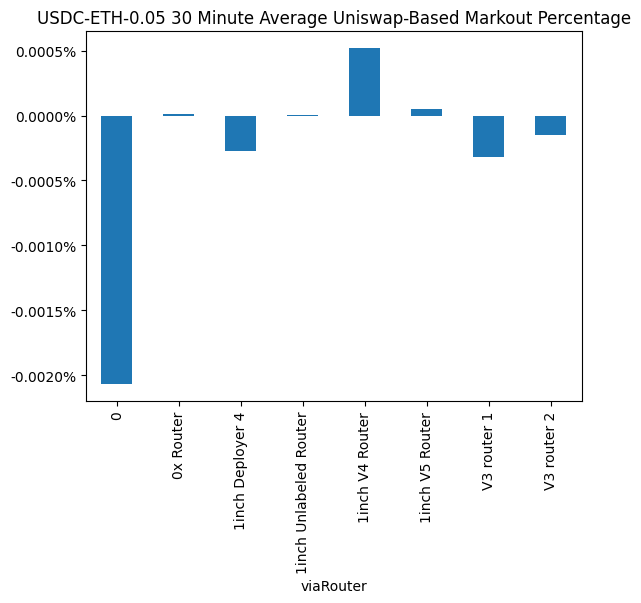

viaRouter
0                         0.003819
0x Router                 0.000438
1inch Deployer 4         -0.000297
1inch Unlabeled Router    0.000003
1inch V4 Router           0.000725
1inch V5 Router           0.000032
V3 router 1              -0.000838
V3 router 2               0.000783
Name: markout_45m, dtype: float64


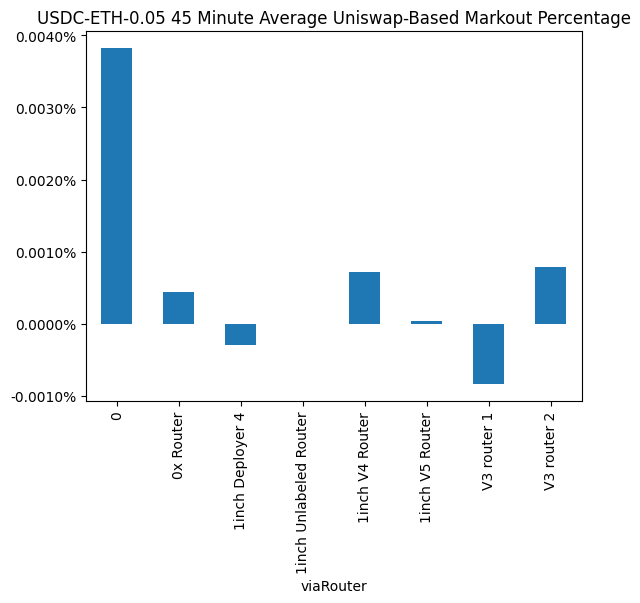

viaRouter
0                         0.015791
0x Router                 0.000458
1inch Deployer 4         -0.000326
1inch Unlabeled Router    0.000161
1inch V4 Router           0.000733
1inch V5 Router           0.000036
V3 router 1              -0.000460
V3 router 2               0.001398
Name: markout_60m, dtype: float64


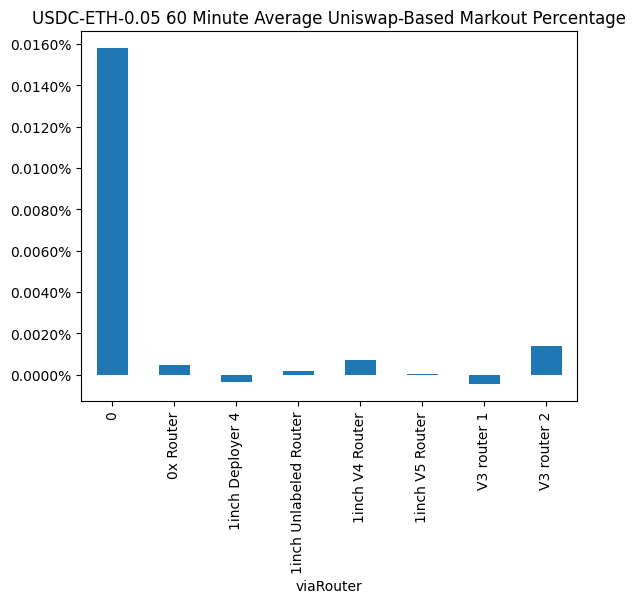

viaRouter
0                         0.020985
0x Router                 0.000686
1inch Deployer 4         -0.000385
1inch Unlabeled Router    0.000273
1inch V4 Router           0.000857
1inch V5 Router           0.000045
V3 router 1              -0.000477
V3 router 2               0.002442
Name: markout_90m, dtype: float64


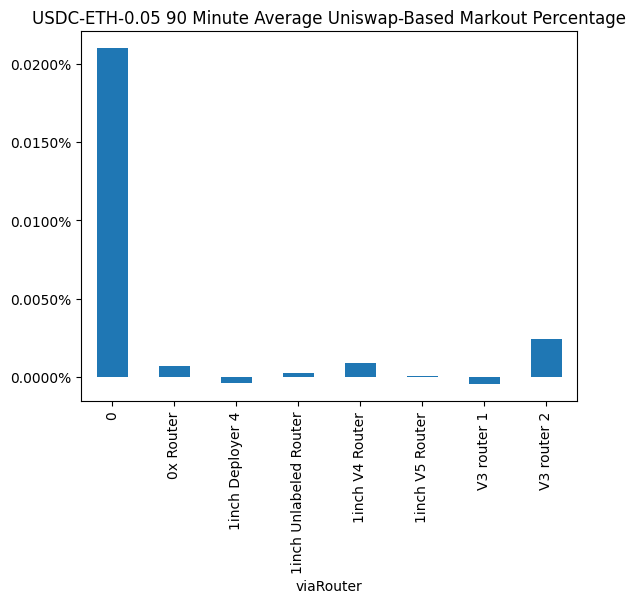

viaRouter
0                         0.025499
0x Router                 0.000539
1inch Deployer 4         -0.000322
1inch Unlabeled Router    0.000396
1inch V4 Router           0.000892
1inch V5 Router           0.000088
V3 router 1              -0.000172
V3 router 2               0.003847
Name: markout_120m, dtype: float64


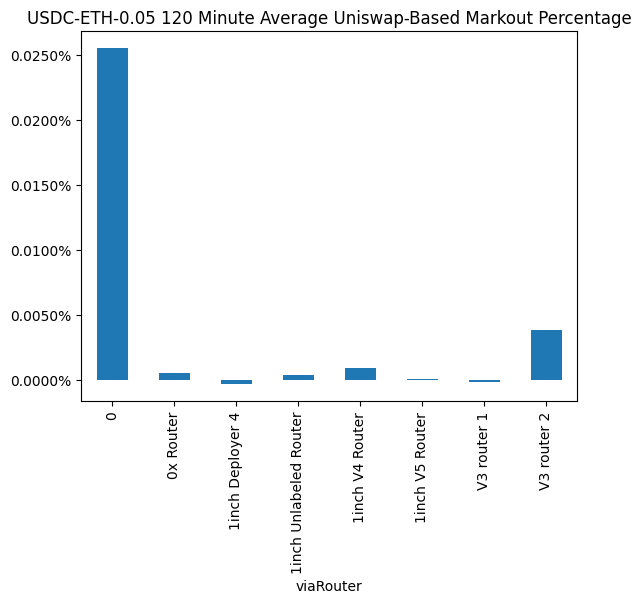

viaRouter
0                        -0.008153
0x Router                 0.000759
1inch Deployer 4         -0.000559
1inch Unlabeled Router    0.000304
1inch V4 Router           0.001808
1inch V5 Router           0.000226
V3 router 1              -0.002167
V3 router 2               0.010625
Name: markout_720m, dtype: float64


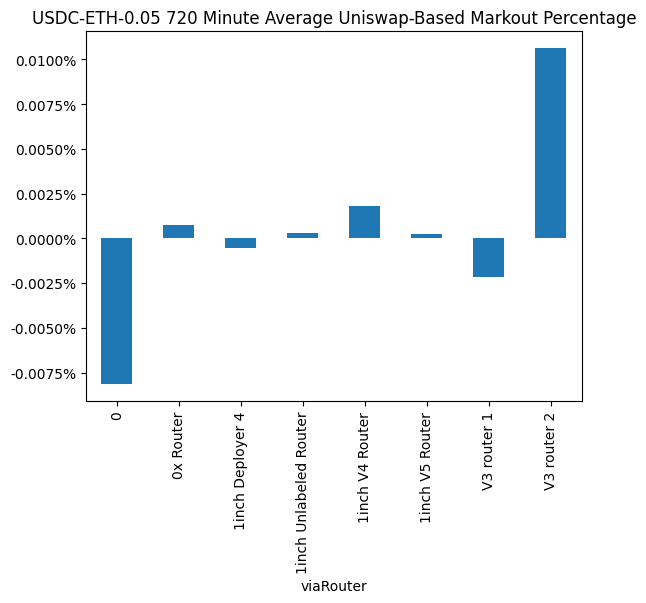

In [230]:
for h_minutes_ in LAGS_:
    datum_ = (
        100*swap_data_.groupby("viaRouter")[f"markout_{h_minutes_}m"].sum() /
        swap_data_.groupby("viaRouter", group_keys=False)["amount1"].apply(np.abs).sum()
    )
    ax = datum_.plot.bar()
    ax.set_title(f"{pool_name_} {h_minutes_} Minute Average Uniswap-Based Markout Percentage")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.4f}%'.format(y))) 
    print(datum_)
    plt.show()